In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import glob
from torchvision import transforms
from torch.utils import data
from PIL import Image

In [3]:
img_dir = r'./dataset2/*.jpg'

In [4]:
imgs = glob.glob(img_dir)

In [5]:
imgs[:3]

['./dataset2\\cloudy1.jpg',
 './dataset2\\cloudy10.jpg',
 './dataset2\\cloudy100.jpg']

In [6]:
species = ['cloudy', 'rain', 'shine', 'sunrise']

In [7]:
species_to_idx = dict((c, i) for i, c in enumerate(species))

In [8]:
species_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [9]:
idx_to_species = dict((v, k) for k, v in species_to_idx.items())

In [10]:
idx_to_species

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

In [11]:
labels = []
for img in imgs:
    for i, c in enumerate(species):
        if c in img:
            labels.append(i)

In [12]:
labels[:3]

[0, 0, 0]

In [13]:
count = len(imgs)
print(count)

1122


In [14]:
np.random.seed(2022)
index = np.random.permutation(count)
imgs = np.array(imgs)[index]
labels = np.array(labels, dtype=np.int64)[index]

In [15]:
sep = int(count*0.8)
train_imgs = imgs[ :sep]
train_labels = labels[ :sep]
test_imgs = imgs[sep: ]
test_labels = labels[sep: ]

In [ ]:
cloudy134.jpg

In [23]:
pil_img = Image.open('dataset2/cloudy134.jpg')

In [24]:
trans_img = transforms.RandomHorizontalFlip(p=1)(pil_img) 

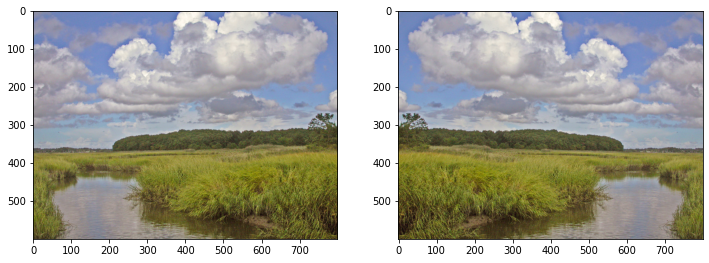

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(pil_img)
plt.subplot(1, 2, 2)
plt.imshow(trans_img)
plt.show()
plt.savefig('5_1.jpg')

In [45]:
pil_img = Image.open('dataset2/cloudy134.jpg')
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224))
])

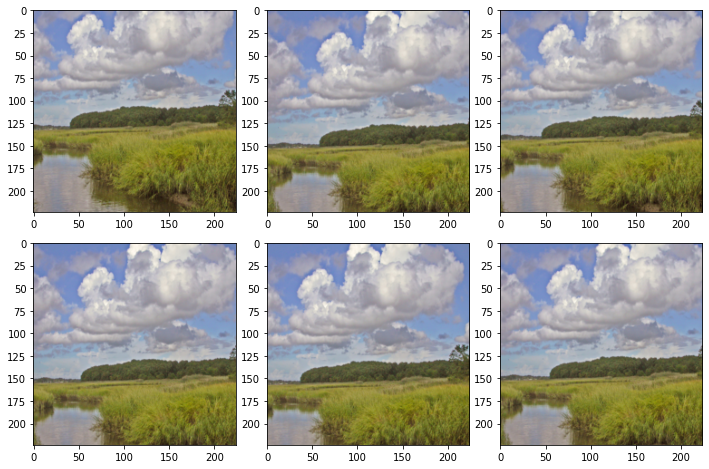

In [51]:
plt.figure(figsize=(12, 8))
for i in range(6):
    img = transform(pil_img)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
plt.subplots_adjust(wspace=0.15, hspace=0.15)
plt.savefig('5_0.jpg')

In [15]:
transforms.ColorJitter()

ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)

In [16]:
train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.05, 0.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [17]:
test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [18]:
class WT_dataset(data.Dataset):
    def __init__(self, imgs_path, lables, transform):
        self.imgs_path = imgs_path
        self.lables = lables
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        lable = self.lables[index]
        
        pil_img = Image.open(img_path)
        pil_img = pil_img.convert("RGB")
        pil_img = self.transform(pil_img)
        return pil_img, lable

    def __len__(self):
        return len(self.imgs_path)

In [19]:
train_dataset = WT_dataset(train_imgs, train_labels, train_transform)
test_dataset = WT_dataset(test_imgs, test_labels, test_transform)

In [20]:
BTACH_SIZE = 16

In [21]:
train_dl = torch.utils.data.DataLoader(
                                       train_dataset,
                                       batch_size=BTACH_SIZE,
                                       shuffle=True
)

In [22]:
test_dl = torch.utils.data.DataLoader(
                                       test_dataset,
                                       batch_size=BTACH_SIZE,
)

In [23]:
imgs, labels = next(iter(train_dl))

In [24]:
imgs.shape

torch.Size([16, 3, 224, 224])

In [25]:
imgs[0].shape

torch.Size([3, 224, 224])

In [26]:
im = imgs[0].permute(1, 2, 0)

In [27]:
im.shape

torch.Size([224, 224, 3])

In [28]:
im = im.numpy()

In [29]:
type(im)

numpy.ndarray

In [30]:
im.shape

(224, 224, 3)

In [31]:
im.max(), im.min()

(1.0, -1.0)

In [32]:
im = (im + 1)/2

In [33]:
im.max(), im.min()

(1.0, 0.0)

Text(0.5, 1.0, 'cloudy')

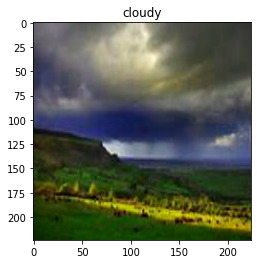

In [34]:
plt.imshow(im)
plt.title(idx_to_species[labels[0].item()])

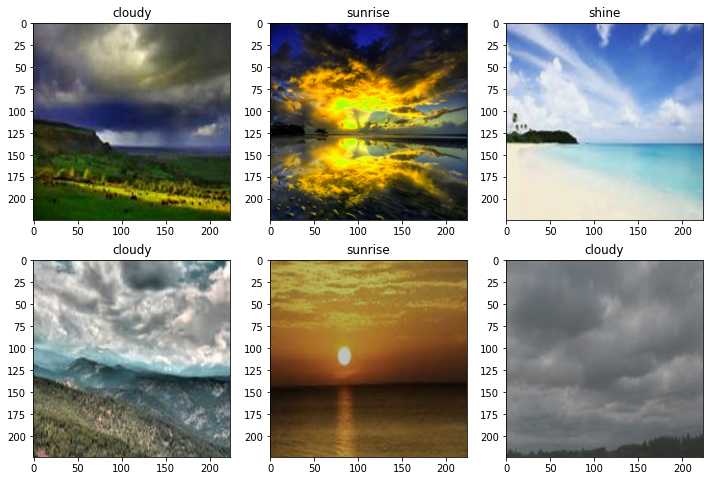

In [35]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
    img = (img.permute(1, 2, 0).numpy() + 1)/2
    plt.subplot(2, 3, i+1)
    plt.title(idx_to_species.get(label.item()))
    plt.imshow(img)

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


# 使用VGG预训练模型

In [37]:
model = torchvision.models.vgg16(pretrained=True)

In [38]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
for param in model.features.parameters():
    param.requires_grad = False

In [40]:
model.classifier[-1].out_features = 4

In [41]:
model = model.to(device)

# 训练代码

In [42]:
loss_fn = nn.CrossEntropyLoss()

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [44]:
#此处使用训练代码

In [45]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_loss += loss.item()
    train_loss /= num_batches
    correct /= size
    return train_loss, correct

In [46]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size

    return test_loss, correct

In [47]:
epochs = 40

In [48]:
def fit(epochs, train_dl, test_dl, model, loss_fn, optimizer):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optimizer)
        epoch_test_loss, epoch_test_acc = test(test_dl, model)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)
    
        template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                    "test_loss: {:.5f}, test_acc: {:.1f}%")
        print(template.format(
              epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    print("Done!")
    
    return train_loss, test_loss, train_acc, test_acc

In [49]:
train_loss, test_loss, train_acc, test_acc = fit(epochs, 
                                                 train_dl, 
                                                 test_dl, 
                                                 model, 
                                                 loss_fn, 
                                                 optimizer)

C:\Users\guanghua\miniconda3\envs\tch19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0, train_loss: 0.94812, train_acc: 74.7% ,test_loss: 0.12810, test_acc: 94.2%
epoch: 1, train_loss: 0.14031, train_acc: 95.9% ,test_loss: 0.13117, test_acc: 94.7%
epoch: 2, train_loss: 0.09918, train_acc: 96.7% ,test_loss: 0.09787, test_acc: 96.0%
epoch: 3, train_loss: 0.05111, train_acc: 98.7% ,test_loss: 0.09478, test_acc: 95.1%
epoch: 4, train_loss: 0.06041, train_acc: 97.8% ,test_loss: 0.08457, test_acc: 96.4%
epoch: 5, train_loss: 0.05353, train_acc: 97.8% ,test_loss: 0.15755, test_acc: 93.8%
epoch: 6, train_loss: 0.05226, train_acc: 98.4% ,test_loss: 0.16623, test_acc: 94.7%
epoch: 7, train_loss: 0.03800, train_acc: 98.6% ,test_loss: 0.15638, test_acc: 95.1%
epoch: 8, train_loss: 0.03279, train_acc: 99.0% ,test_loss: 0.08708, test_acc: 97.3%
epoch: 9, train_loss: 0.02773, train_acc: 99.0% ,test_loss: 0.12918, test_acc: 96.4%
epoch:10, train_loss: 0.04621, train_acc: 98.4% ,test_loss: 0.41249, test_acc: 88.9%
epoch:11, train_loss: 0.02526, train_acc: 99.2% ,test_loss: 0.163

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.imshow(trans_img)
plt.show()
plt.savefig('5_1.jpg')

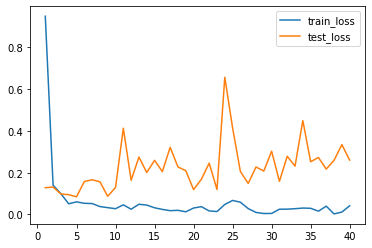

In [50]:

plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()
plt.savefig('5-4.jpg')

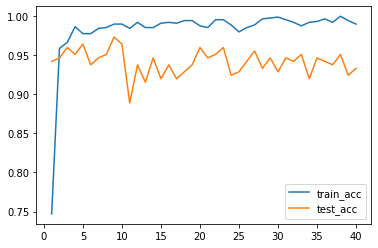

In [51]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

# 微调

In [52]:
for param in model.parameters():
    param.requires_grad = True

In [53]:
extend_epochs = 15

In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [55]:
train_loss_, test_loss_, train_acc_, test_acc_ = fit(extend_epochs, 
                                                 train_dl, 
                                                 test_dl, 
                                                 model, 
                                                 loss_fn, 
                                                 optimizer)

epoch: 0, train_loss: 0.02427, train_acc: 99.0% ,test_loss: 0.37153, test_acc: 94.7%
epoch: 1, train_loss: 0.03885, train_acc: 99.3% ,test_loss: 0.28517, test_acc: 94.7%
epoch: 2, train_loss: 0.01681, train_acc: 99.7% ,test_loss: 0.23416, test_acc: 95.1%
epoch: 3, train_loss: 0.00259, train_acc: 99.9% ,test_loss: 0.20128, test_acc: 94.7%
epoch: 4, train_loss: 0.06863, train_acc: 99.0% ,test_loss: 0.08454, test_acc: 96.4%
epoch: 5, train_loss: 0.02859, train_acc: 99.6% ,test_loss: 0.23434, test_acc: 95.1%
epoch: 6, train_loss: 0.01185, train_acc: 99.6% ,test_loss: 0.14643, test_acc: 95.1%
epoch: 7, train_loss: 0.02131, train_acc: 99.4% ,test_loss: 0.37981, test_acc: 93.3%
epoch: 8, train_loss: 0.01151, train_acc: 99.4% ,test_loss: 0.28934, test_acc: 94.7%
epoch: 9, train_loss: 0.00805, train_acc: 99.9% ,test_loss: 0.22748, test_acc: 95.1%
epoch:10, train_loss: 0.02054, train_acc: 99.6% ,test_loss: 0.43045, test_acc: 93.3%
epoch:11, train_loss: 0.04287, train_acc: 99.2% ,test_loss: 0.094

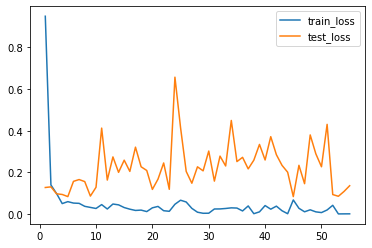

In [56]:
plt.plot(range(1, epochs+extend_epochs+1), train_loss+train_loss_, label='train_loss')
plt.plot(range(1, epochs+extend_epochs+1), test_loss+test_loss_, label='test_loss')
plt.legend()

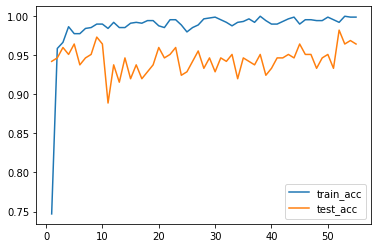

In [57]:
plt.plot(range(1, epochs+extend_epochs+1), train_acc+train_acc_, label='train_acc')
plt.plot(range(1, epochs+extend_epochs+1), test_acc+test_acc_, label='test_acc')
plt.legend()

# 使用Resnet预训练模型